In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteV6N0F3/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteV6N0F3/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
tImage = 0
tMask = 0

In [3]:
def resize(input_image, input_mask):
    global tImage, tMask
    print(type(input_image))
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
    b = np.uint8(2)
    a = np.uint8(0)
    input_mask = tf.where( tf.equal( np.uint8(3), input_mask ), np.uint8(1) * tf.ones_like( input_mask ), input_mask )
    # tf.assign( input_mask, t2 )
    # tImage = input_image.numpy()
    # tMask = input_mask
    return input_image, input_mask

In [4]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [5]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [6]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

In [7]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


In [ ]:
# tImage.numpy()

In [ ]:
# display([tImage.])

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
train_dataset.

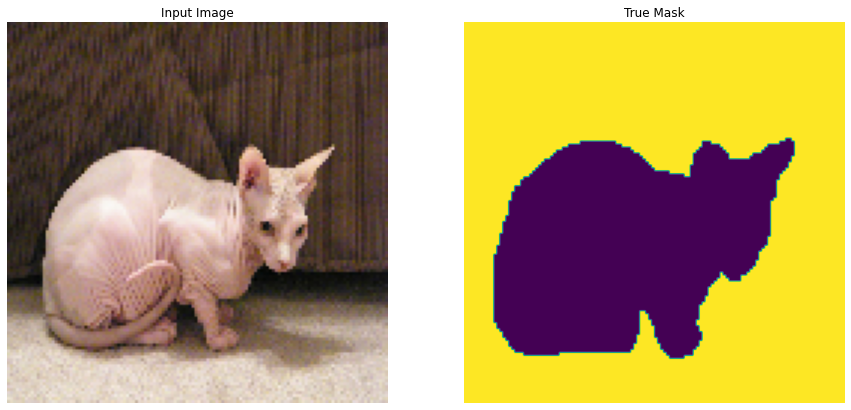

In [9]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [10]:
sample_mask2 = sample_mask.numpy().reshape((128 * 128))
tt = { }
for i in sample_mask2:
    if str(i) not in tt:
        tt[str(i)] = 1
    else:
        tt[str(i)] = tt[str(i)] + 1
tt

{'0': 5355, '1': 11029}

{'0': 9869, '2': 1637, '255': 4878}

In [11]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [12]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [13]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [14]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [15]:
unet_model = build_unet_model()

In [16]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [17]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
unet_model.load_weights("/content/drive/MyDrive/ColabNotebooks/project/testUNet/m3")

In [18]:
NUM_EPOCHS = 20
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 98s 1s/step - loss: 0.7370 - accuracy: 0.5821 - val_loss: 0.6109 - val_accuracy: 0.6303
Epoch 2/20
57/57 [==============================] - 73s 1s/step - loss: 0.5182 - accuracy: 0.7385 - val_loss: 0.4606 - val_accuracy: 0.7966
Epoch 3/20
57/57 [==============================] - 65s 1s/step - loss: 0.4426 - accuracy: 0.8019 - val_loss: 0.3975 - val_accuracy: 0.8248
Epoch 4/20
57/57 [==============================] - 65s 1s/step - loss: 0.4040 - accuracy: 0.8245 - val_loss: 0.3498 - val_accuracy: 0.8497
Epoch 5/20
57/57 [==============================] - 65s 1s/step - loss: 0.3647 - accuracy: 0.8426 - val_loss: 0.3279 - val_accuracy: 0.8616
Epoch 6/20
57/57 [==============================] - 66s 1s/step - loss: 0.3351 - accuracy: 0.8567 - val_loss: 0.3096 - val_accuracy: 0.8690
Epoch 7/20
57/57 [==============================] - 65s 1s/step - loss: 0.3256 - accuracy: 0.8616 - val_loss: 0.2857 - val_accuracy: 0.8805
Epoch 8/20
57/57 [==

In [19]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]
def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


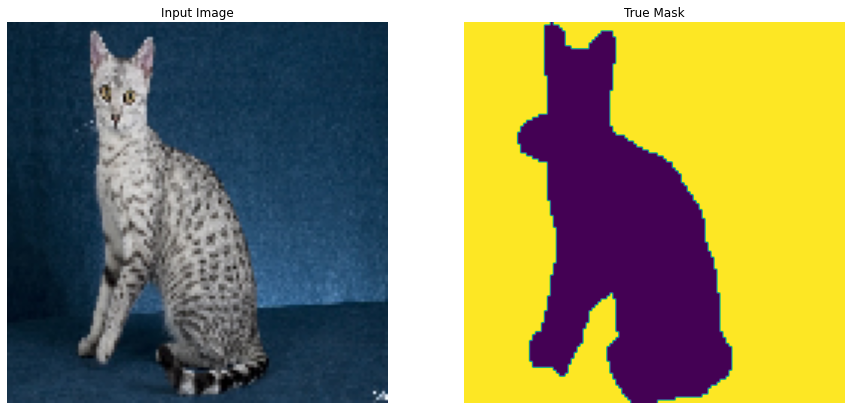

In [24]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
sample_image.shape

TensorShape([128, 128, 3])

In [ ]:
sample_mask.shape

TensorShape([128, 128, 1])

In [ ]:
predicted_mask.shape

(128, 128, 3)

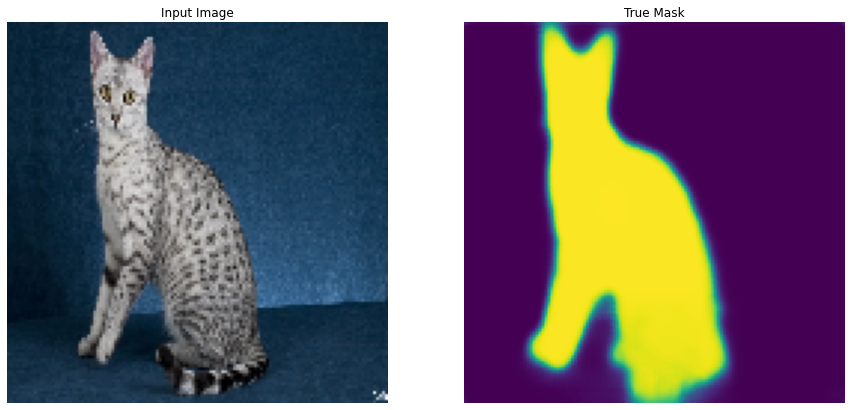

In [25]:
sample_image2 = sample_image.numpy().reshape((1, 128, 128, 3))
predicted_mask = unet_model.predict(sample_image2)
# predicted_mask.shape
predicted_mask = predicted_mask.reshape((128, 128, 2))
predicted_mask1 = np.array([0.0 for i in range(128 * 128)])
predicted_mask1 = predicted_mask1.reshape((128, 128, 1))
def getPred(dFrom, dTo, v):
    for i in range(128):
        for j in range(128):
            dTo[i][j][0] = dFrom[i][j][v]
getPred(predicted_mask, predicted_mask1, 0)
display([sample_image, predicted_mask1])

In [22]:
predicted_mask[0][0]

array([0.18560146, 0.8143985 ], dtype=float32)

In [ ]:
sample_mask2 = predicted_mask1.reshape((128 * 128))
tt = [ ]
for i in sample_mask2:
    if i not in tt:
        tt.append(i)
tt

In [ ]:
a = float('nan')
a == float('nan')

False

In [ ]:
unet_model2 = unet_model

In [ ]:
unet_model2.save("/content/drive/MyDrive/ColabNotebooks/project/testUNet/m2")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ColabNotebooks/project/testUNet/m2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ColabNotebooks/project/testUNet/m2/assets


In [ ]:
unet_model.save("/content/drive/MyDrive/ColabNotebooks/project/testUNet/m3")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ColabNotebooks/project/testUNet/m3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ColabNotebooks/project/testUNet/m3/assets
